In [22]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, shuffle

from scipy.integrate import simps
import pandas as pd
import sys
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

sys.path.append("..")
from utils.load_las_data import normalize_z_with_minz_in_a_radius

from config import args
from utils.load_las_data import *
from utils.useful_functions import *
import os
import numpy as np; np. set_printoptions(suppress=True);  # display values without scientific notation
import pandas as pd
from laspy.file import File
from sklearn.neighbors import NearestNeighbors
import warnings
import random

In [23]:
args.znorm_radius_in_meters = 1.5

In [111]:
def load_and_clean_single_las(las_filename):
    """Load a LAD file into a np.array, convert coordinates to meters, clean a few anomalies in plots."""
    # Parse LAS files
    las = File(las_filename, mode="r")
    x_las = las.X / 100  # we divide by 100 as all the values in las are in cm
    y_las = las.Y / 100
    z_las = las.Z / 100
    r = las.Red
    g = las.Green
    b = las.Blue
    nir = las.nir
    intensity = las.intensity
    return_num = las.return_num
    num_returns = las.num_returns
    points_nparray = np.asarray(
        [x_las, y_las, z_las, r, g, b, nir, intensity, return_num, num_returns]
    ).T

    # There is a file with 2 points 60m above others (maybe birds), we delete these points
    if las_filename.endswith("Releve_Lidar_F70.las"):
        points_nparray = points_nparray[points_nparray[:, 2] < 640]
    # We do the same for the intensity
    if las_filename.endswith("POINT_OBS8.las"):
        points_nparray = points_nparray[points_nparray[:, -2] < 32768]
    if las_filename.endswith("Releve_Lidar_F39.las"):
        points_nparray = points_nparray[points_nparray[:, -2] < 20000]

    # get the center of a rectangle bounding the points
    xy_centers = [
        (x_las.max() - x_las.min()) / 2.0,
        (y_las.max() - y_las.min()) / 2.0,
    ]
    return points_nparray, xy_centers


def load_my_norm_data(args, subset=[]):

    # We open las files and create a training dataset
    nparray_clouds_dict = {}  # dict to store numpy array with each plot separately
    xy_centers_dict = (
        {}
    )  # we keep track of plots means to reverse the normalisation in the future

    # We iterate through las files and transform them to np array
    las_filenames = get_files_of_type_in_folder(args.las_placettes_folder_path, ".las")
    if subset:
        las_filenames = [l for l in las_filenames if any(b in l for b in subset) ]
    all_points_nparray = np.empty((0, len(args.input_feats)))
    for las_filename in las_filenames:
        # Parse LAS files
        points_nparray, xy_centers = load_and_clean_single_las(las_filename)
        points_nparray = transform_features_of_plot_cloud(
            points_nparray, args
        )
        all_points_nparray = np.append(all_points_nparray, points_nparray, axis=0)
        plot_name = get_filename_no_extension(las_filename)
        nparray_clouds_dict[plot_name] = points_nparray
        xy_centers_dict[plot_name] = xy_centers

    return all_points_nparray, nparray_clouds_dict, xy_centers_dict


def select_my_clouds(plots_of_interest = []):
    # F49 = nparray_clouds_dict["Releve_Lidar_F49"][:,:3]
    # F68 = nparray_clouds_dict["Releve_Lidar_F68"][:,:3]  # Vm everywhere
    # OBS_2021_6 = nparray_clouds_dict["2021_POINT_OBS6"][:,:3]  # "hyper flag en termes de MNT"
    # F20 = nparray_clouds_dict["Releve_Lidar_F20"][:,:3]  # "hyper flag en termes de MNT"
    if not plots_of_interest:
        plots_of_interest = [
            "Releve_Lidar_F68",
            "Releve_Lidar_F69",
            "2021_POINT_OBS9",  # grass 100%, high slope: 0-3m to 0-0.4cm slope with 1.5
            "Releve_Lidar_F49",  # loads of high vegetation. Ok with 1.5m
            "Releve_Lidar_F68",  # dense bushes. Ok with 1.5 : adds contrast.
            "2021_POINT_OBS6",  # 75% grass (subestimation of model). might add contrats linked to grass
            "Releve_Lidar_F20",  # 75% grass, 25% mid veg. ok,
            "2021_POINT_OBS59",
        ]
    # focus on medium veg
    plots_of_interest = plots_of_interest + []
    selection = {
        key: value
        for key, value in nparray_clouds_dict.items()
        if key in plots_of_interest
    }
    return selection
def view_distribution(params, all_z):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = np.linspace(0, 2, 100)
    plt.hist(all_z, bins=50, range=(0, 2), density=True, histtype='stepfilled', alpha=0.2)
    plt.plot(
        x, params["phi"] * gamma.pdf(x, params["a_g"], 0, params["scale_g"]), "r-", lw=1, label="gamma1"
    )
    if "phi_2" in params:
        plt.plot(
            x, params["phi_2"] * gamma.pdf(x, params["a_v"], 0, params["scale_v"]), "k-", lw=1, label="gamma2"
        )
    plt.tight_layout()
    axes = plt.gca()
    axes.set_ylim([0, 1.1])
    plt.show(block=True)

In [25]:
all_points_nparray, nparray_clouds_dict, xy_centers_dict = load_my_norm_data(args)
selection = select_my_clouds()

Likelihood at init: 0.928
    NR it 0 - obj = 1.391 -0.657
    NR it 1 - obj = 0.621 0.849
    NR it 2 - obj = 0.224 0.246
    NR it 3 - obj = 0.047 0.031
    NR it 4 - obj = 0.003 0.001
    NR it 5 - obj = 0.000 0.000
Newton Rachson terminated
Likelihood at ite 0: 2.434
    NR it 0 - obj = 2.004 0.104
    NR it 1 - obj = 0.813 0.010
    NR it 2 - obj = 0.240 0.000
    NR it 3 - obj = 0.033 0.000
    NR it 4 - obj = 0.001 0.000
Newton Rachson terminated
Likelihood at ite 1: 1.883
    NR it 0 - obj = 0.533 0.006
    NR it 1 - obj = 0.140 0.000
    NR it 2 - obj = 0.014 0.000
    NR it 3 - obj = 0.000 -0.000
Newton Rachson terminated
Likelihood at ite 2: 1.939
    NR it 0 - obj = 0.722 0.053
    NR it 1 - obj = 0.200 0.003
    NR it 2 - obj = 0.023 0.000
    NR it 3 - obj = 0.000 0.000
Newton Rachson terminated
Likelihood at ite 3: 1.871
    NR it 0 - obj = 0.430 0.012
    NR it 1 - obj = 0.094 0.000
    NR it 2 - obj = 0.006 0.000
    NR it 3 - obj = 0.000 0.000
Newton Rachson terminate

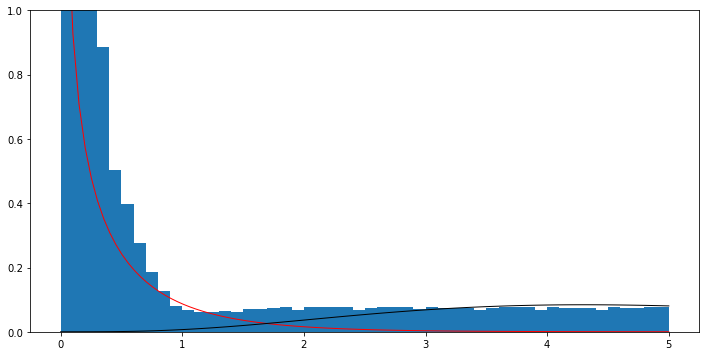

In [26]:
from em_gamma.get_gamma_parameters_em import get_gamma_parameters

# Fit a mixture of 2 gamma distribution if not already done
all_z = all_points_nparray[:, 2]
params = get_gamma_parameters(all_z, args)
view_distribution(params, all_z)

<IPython.core.display.Javascript object>


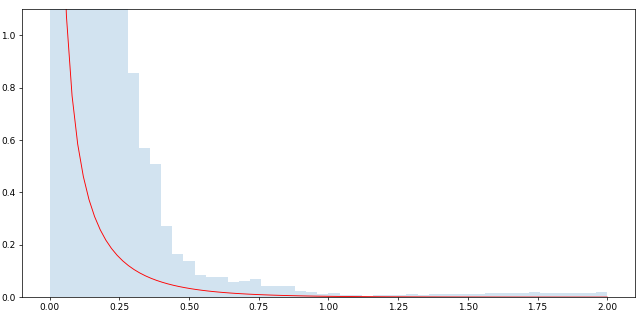

In [112]:
view_distribution(params, all_z)

# Subselection

In [176]:
all_points_nparray, nparray_clouds_dict, xy_centers_dict = load_my_norm_data(args)

100
{'phi': 1, 'a_g': 0.43399137016008593, 'scale_g': 4.304297013680012}


<IPython.core.display.Javascript object>


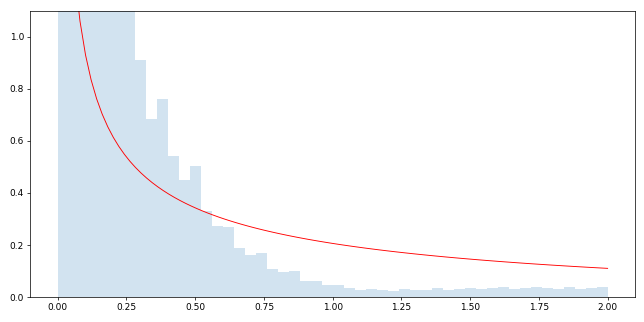

In [206]:
from scipy.stats import gamma

# ATTENTION: fit beta should be named fit_scale
# SELECT VB PLOTS
df = pd.read_csv(args.gt_file_path)
df = df[df["COUV_INTER"]<=10]
df = df[df["COUV_HAUTE"]>=0]
subset = df.Name.values.tolist()
print(len(subset))
selection = select_my_clouds(plots_of_interest=subset)
all_points_selection = np.empty((0, len(args.input_feats)))
for key in selection:
    all_points_selection = np.append(all_points_selection, selection[key], axis=0)
all_z = all_points_selection[:, 2]
fit_alpha, fit_loc, fit_beta=gamma.fit(all_z)
fit_alpha, fit_loc, fit_beta
# params1 = {"phi":1, "a_g":1/fit_beta, "scale_g":fit_alpha}
params1 = {"phi":1, "a_g":fit_alpha, "scale_g":fit_beta}
print(params1)
view_distribution(params1, all_z)

<IPython.core.display.Javascript object>


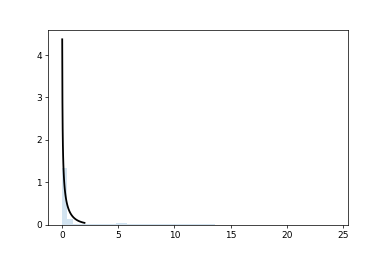

In [211]:
from scipy.stats import gamma

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.hist(all_z, bins=50,density=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, gamma.pdf(x, params1["a_g"]), 'k-', lw=2, label='frozen pdf')

In [207]:
params1["a_g"]/params1["scale_g"]

0.10082746817442313

N 40
{'phi': 1, 'a_g': 0.688871200407912, 'scale_g': 4.782526849156168}


<IPython.core.display.Javascript object>


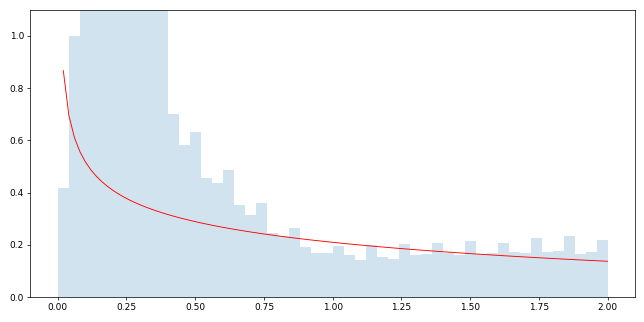

In [212]:
from scipy.stats import gamma

# SELECT VM and VH PLOTS
df = pd.read_csv(args.gt_file_path)
df = df[df["COUV_INTER"]>=50]
df = df[df["COUV_HAUTE"]>=0]
subset = df.Name.values.tolist()
print("N",len(subset))
selection = select_my_clouds(plots_of_interest=subset)
all_points_selection = np.empty((0, len(args.input_feats)))
for key in selection:
    all_points_selection = np.append(all_points_selection, selection[key], axis=0)
all_z = all_points_selection[:, 2]
fit_alpha, fit_loc, fit_beta=gamma.fit(all_z)
fit_alpha, fit_loc, fit_beta
params2 = {"phi":1, "a_g":fit_alpha, "scale_g":fit_beta}
print(params2)
view_distribution(params2, all_z)

<IPython.core.display.Javascript object>


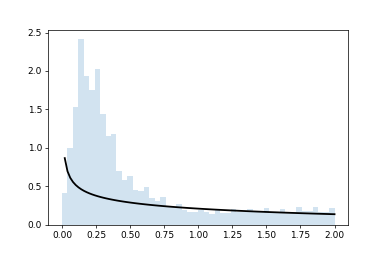

In [224]:
from scipy.stats import gamma

import matplotlib.pyplot as plt
x = np.linspace(0,2,100)
fig, ax = plt.subplots(1, 1)
ax.hist(all_z, bins=50,density=True, histtype='stepfilled', alpha=0.2, range=(0, 2))
ax.plot(x, gamma.pdf(x, params2["a_g"],0, params2["scale_g"]), 'k-', lw=2, label='frozen pdf')

<IPython.core.display.Javascript object>


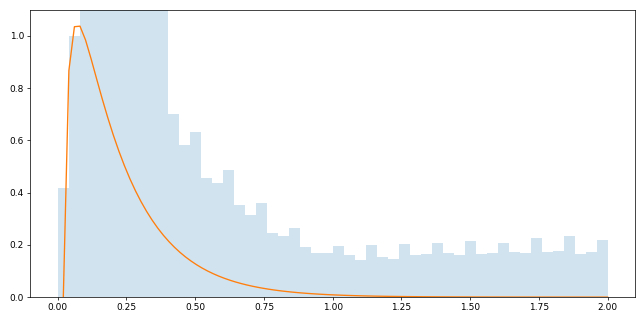

In [204]:
# Difference between gamma2 and gamma1 * 2, with comparable scale (two times since Vb within Wb+Vm also): 
# Distribution of Vmoy !
x = np.linspace(0,2,100)
a = params1["phi"] * gamma.pdf(x, params1["a_g"], 0, params1["scale_g"])
b = params2["phi"] * gamma.pdf(x, params2["a_g"], 0, params2["scale_g"])

max_a = sorted(a)[-2]
max_b = sorted(b)[-2]
# max_a = params1["scale_g"]
# max_b = params2["scale_g"]
ap = a / max_a
bp = b / max_b
x = np.linspace(0,2,100)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.hist(all_z, bins=50, range=(0, 2), density=True, histtype='stepfilled', alpha=0.2)
plt.plot(
    x, (bp-ap) * max(max_a,max_b)
)
plt.tight_layout()
axes = plt.gca()
axes.set_ylim([0, 1.1])
plt.show(block=True)

In [203]:
bp-ap

array([       nan, 0.        , 0.11255309, 0.13439448, 0.13467631,
       0.12780243, 0.11843811, 0.10842749, 0.09857296, 0.08923234,
       0.08055554, 0.07258972, 0.06532994, 0.05874501, 0.05279124,
       0.04741998, 0.04258171, 0.03822835, 0.03431438, 0.03079747,
       0.02763866, 0.02480232, 0.0222561 , 0.01997066, 0.01791953,
       0.0160788 , 0.01442699, 0.01294474, 0.01161467, 0.01042116,
       0.0093502 , 0.00838918, 0.00752682, 0.00675298, 0.00605857,
       0.00543544, 0.00487625, 0.00437445, 0.00392414, 0.00352005,
       0.00315743, 0.00283202, 0.00254001, 0.00227798, 0.00204286,
       0.00183187, 0.00164256, 0.0014727 , 0.00132029, 0.00118356,
       0.00106089, 0.00095083, 0.00085211, 0.00076355, 0.00068412,
       0.00061288, 0.00054899, 0.00049169, 0.00044031, 0.00039425,
       0.00035295, 0.00031592, 0.00028274, 0.00025299, 0.00022633,
       0.00020245, 0.00018105, 0.00016188, 0.0001447 , 0.00012932,
       0.00011555, 0.00010322, 0.00009218, 0.0000823 , 0.00007

In [114]:
from scipy.stats import gamma

# USE ALL PLOTS : gamma3
df = pd.read_csv(args.gt_file_path)
# df = df[df["COUV_INTER"]>=0]
# df = df[df["COUV_HAUTE"]>=0]
subset = df.Name.values.tolist()

selection = select_my_clouds(plots_of_interest=subset)
all_points_selection = np.empty((0, len(args.input_feats)))
for key in selection:
    all_points_selection = np.append(all_points_selection, selection[key], axis=0)
all_z = all_points_selection[:, 2]
fit_alpha, fit_loc, fit_beta=gamma.fit(all_z)
fit_alpha, fit_loc, fit_beta
params1 = {"phi":1, "a_g":1/fit_beta, "scale_g":fit_alpha}
print(params1)
view_distribution(params1, all_z)

0.025054432664913105

In [88]:
x = np.linspace(0+0.000001, 5, 50)
y1 = params["phi"] * gamma.pdf(x, params["a_g"], 0, params["scale_g"])
y2 = params["phi_2"] * gamma.pdf(x, params["a_v"], 0, params["scale_v"])
pd.DataFrame(data=np.vstack([x,y1, y2]).T, columns=["z","likelihood1","likelihood2"]).round(2)

z  likelihood1  likelihood2
0   0.00        33.37         0.00
1   0.10         0.16         0.01
2   0.20         0.10         0.02
3   0.31         0.07         0.03
4   0.41         0.05         0.04
5   0.51         0.04         0.06
6   0.61         0.03         0.07
7   0.71         0.03         0.09
8   0.82         0.02         0.10
9   0.92         0.02         0.11
10  1.02         0.01         0.12
11  1.12         0.01         0.13
12  1.22         0.01         0.14
13  1.33         0.01         0.15
14  1.43         0.01         0.16
15  1.53         0.01         0.17
16  1.63         0.00         0.17
17  1.73         0.00         0.18
18  1.84         0.00         0.18
19  1.94         0.00         0.18
20  2.04         0.00         0.19
21  2.14         0.00         0.19
22  2.24         0.00         0.19
23  2.35         0.00         0.19
24  2.45         0.00         0.19
25  2.55         0.00         0.19
26  2.65         0.00         0.19
27  2.76         0.00         0.18
28  2.86         0.00         0.18
29  2.96         0.00         0.18
30  3.06         0.00         0.18
31  3.16         0.00         0.17
32  3.27         0.00         0.17
33  3.37         0.00         0.17
34  3.47         0.00         0.16
35  3.57         0.00         0.16
36  3.67         0.00         0.16
37  3.78         0.00         0.15
38  3.88         0.00         0.15
39  3.98         0.00         0.14
40  4.08         0.00         0.14
41  4.18         0.00         0.13
42  4.29         0.00         0.13
43  4.39         0.00         0.13
44  4.49         0.00         0.12
45  4.59         0.00         0.12
46  4.69         0.00         0.11
47  4.80         0.00         0.11
48  4.90         0.00         0.11
49  5.00         0.00         0.10

<IPython.core.display.Javascript object>


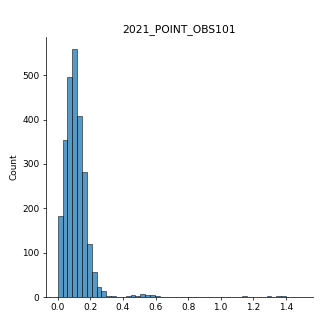

<IPython.core.display.Javascript object>


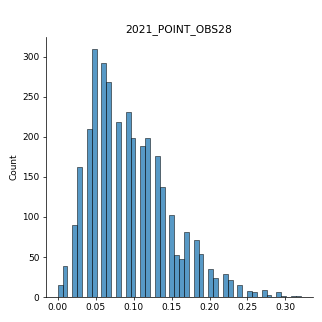

<IPython.core.display.Javascript object>


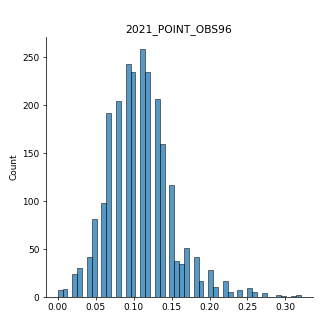

<IPython.core.display.Javascript object>


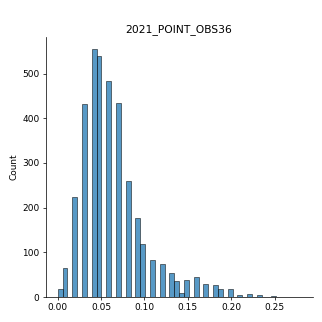

<IPython.core.display.Javascript object>


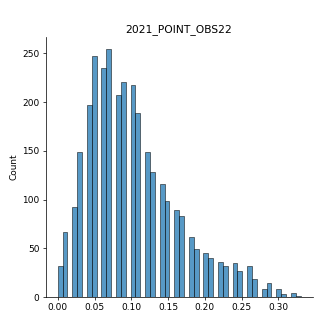

<IPython.core.display.Javascript object>


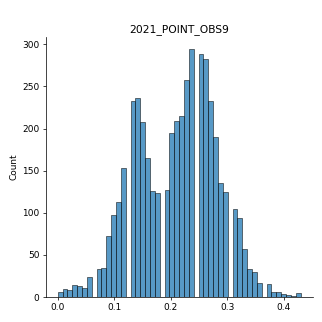

<IPython.core.display.Javascript object>


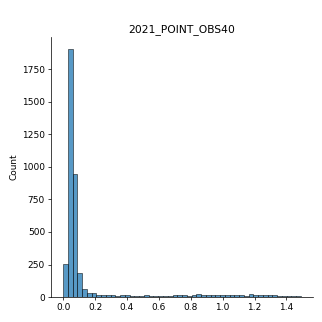

<IPython.core.display.Javascript object>


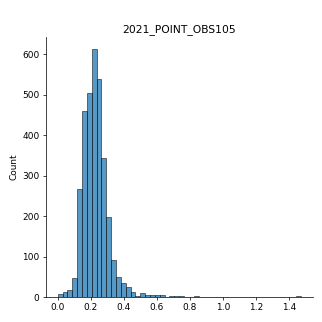

<IPython.core.display.Javascript object>


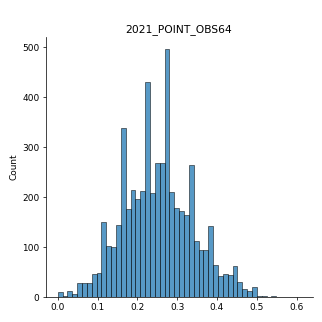

<IPython.core.display.Javascript object>


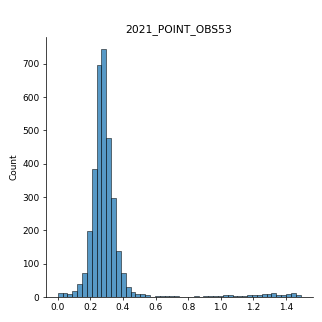

<IPython.core.display.Javascript object>


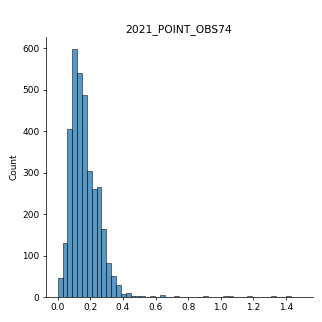

<IPython.core.display.Javascript object>


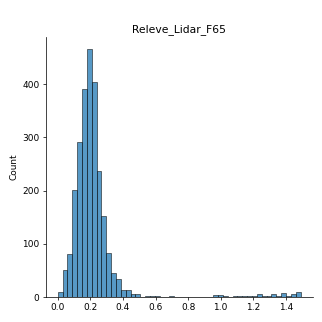

<IPython.core.display.Javascript object>


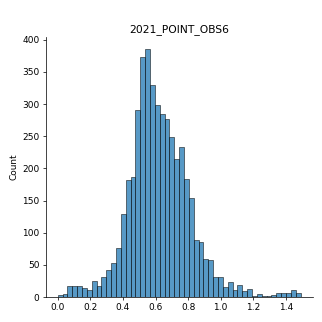

<IPython.core.display.Javascript object>


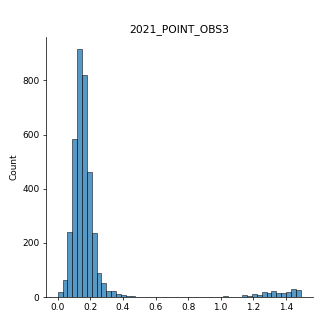

<IPython.core.display.Javascript object>


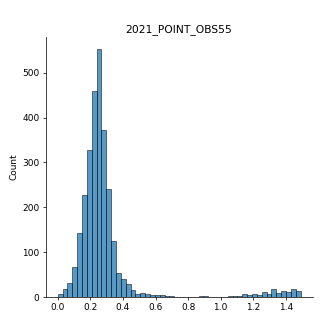

<IPython.core.display.Javascript object>


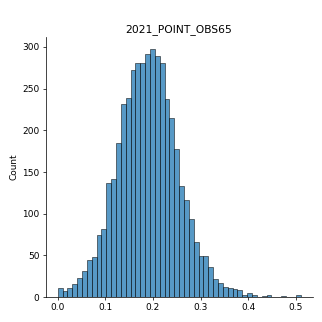

<IPython.core.display.Javascript object>


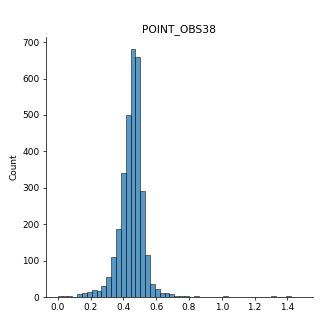

<IPython.core.display.Javascript object>


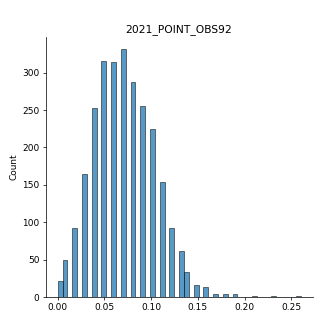

<IPython.core.display.Javascript object>


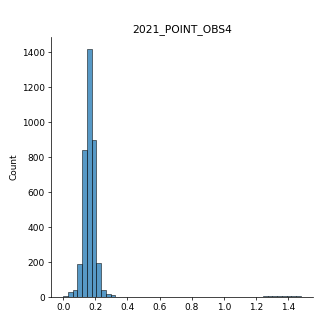

<IPython.core.display.Javascript object>


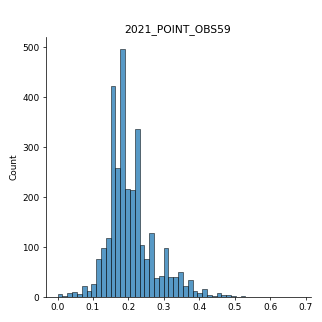

<IPython.core.display.Javascript object>


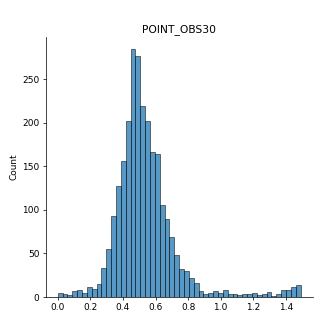

<IPython.core.display.Javascript object>


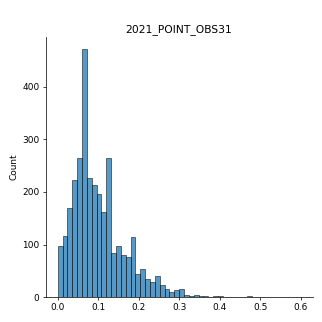

<IPython.core.display.Javascript object>


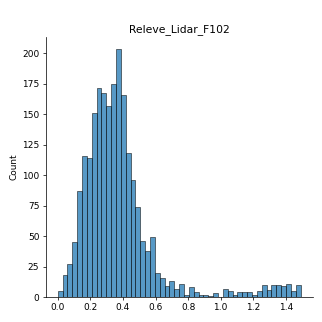

<IPython.core.display.Javascript object>


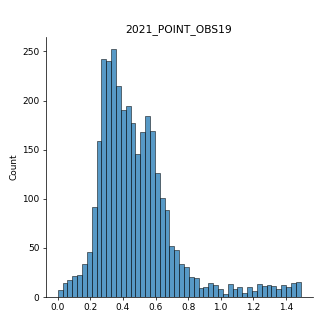

<IPython.core.display.Javascript object>


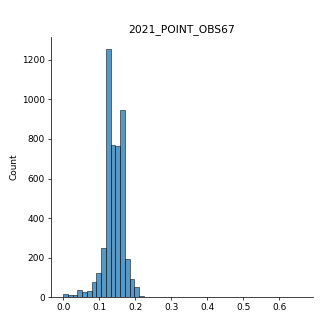

<IPython.core.display.Javascript object>


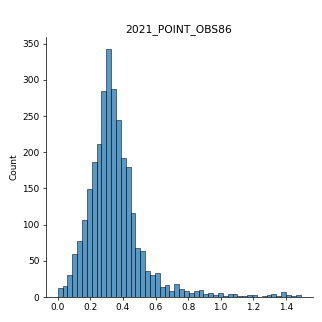

<IPython.core.display.Javascript object>


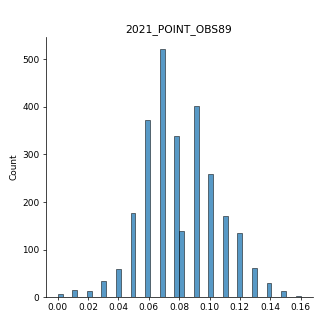

<IPython.core.display.Javascript object>


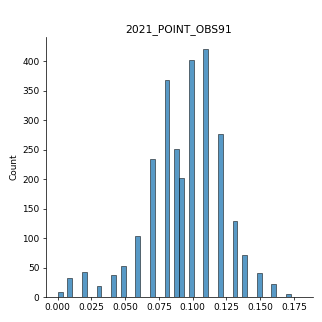

<IPython.core.display.Javascript object>


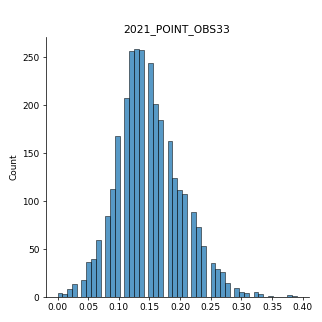

<IPython.core.display.Javascript object>


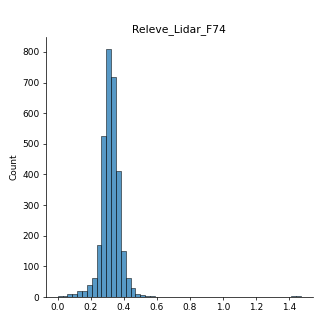

<IPython.core.display.Javascript object>


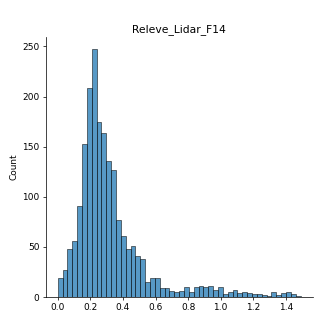

<IPython.core.display.Javascript object>


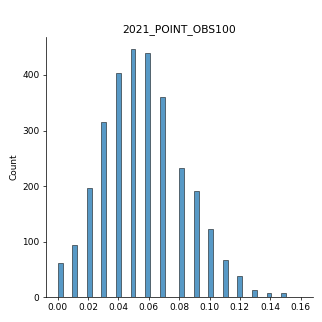

<IPython.core.display.Javascript object>


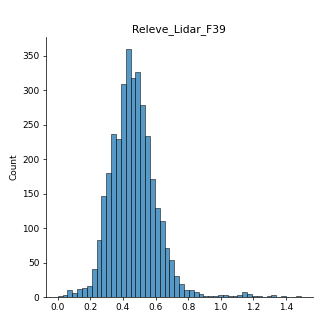

<IPython.core.display.Javascript object>


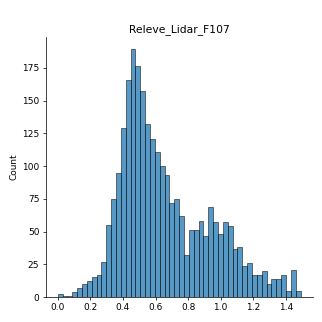

<IPython.core.display.Javascript object>


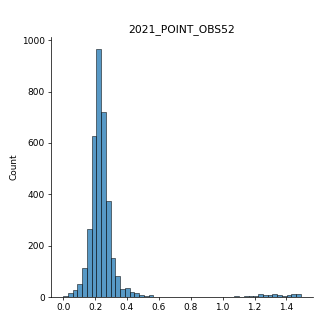

<IPython.core.display.Javascript object>


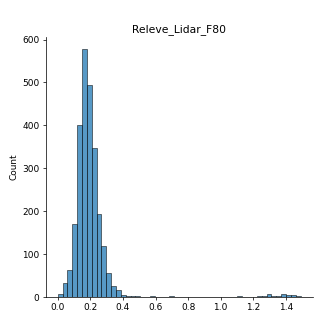

<IPython.core.display.Javascript object>


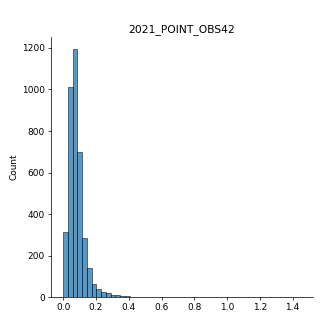

<IPython.core.display.Javascript object>


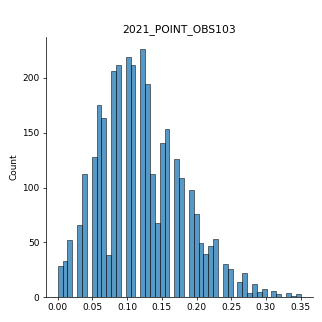

<IPython.core.display.Javascript object>


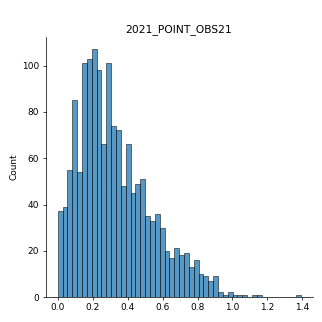

<IPython.core.display.Javascript object>


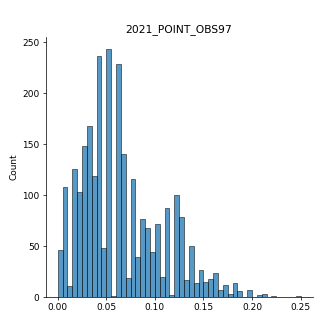

<IPython.core.display.Javascript object>


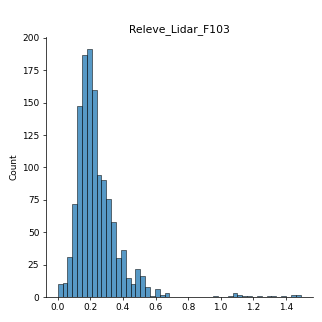

<IPython.core.display.Javascript object>


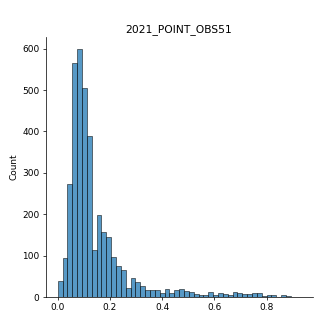

<IPython.core.display.Javascript object>


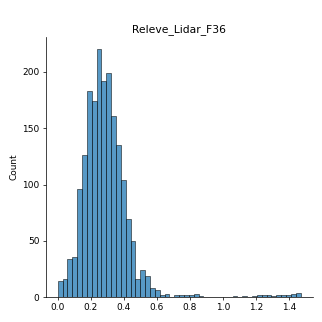

<IPython.core.display.Javascript object>


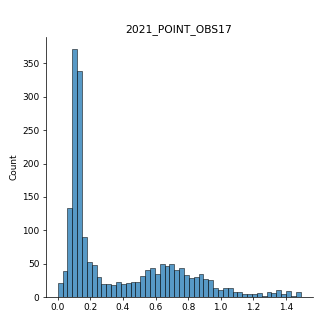

<IPython.core.display.Javascript object>


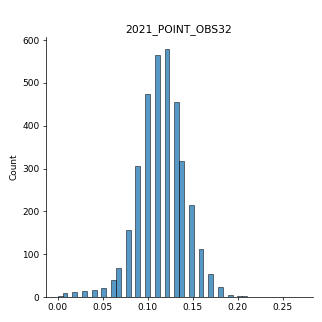

<IPython.core.display.Javascript object>


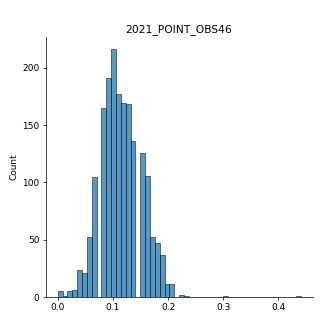

<IPython.core.display.Javascript object>


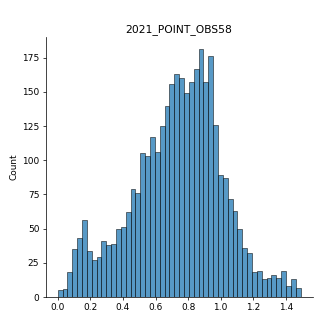

<IPython.core.display.Javascript object>


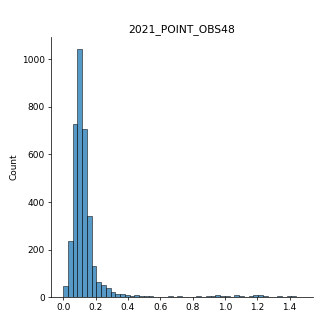

<IPython.core.display.Javascript object>


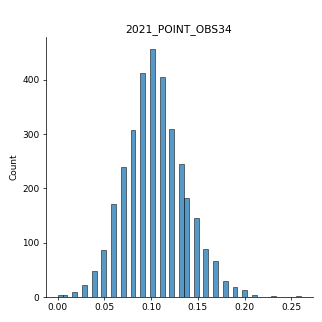

<IPython.core.display.Javascript object>


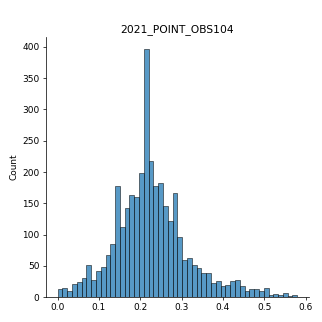

<IPython.core.display.Javascript object>


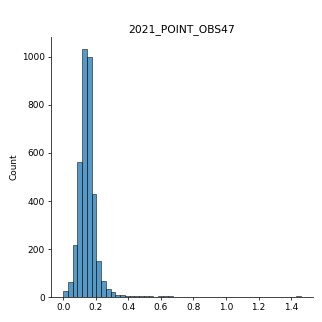

<IPython.core.display.Javascript object>


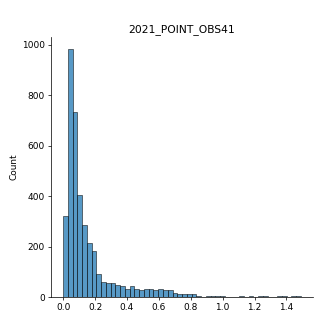

<IPython.core.display.Javascript object>


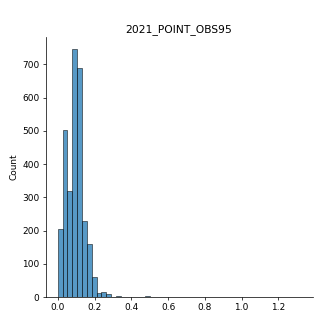

<IPython.core.display.Javascript object>


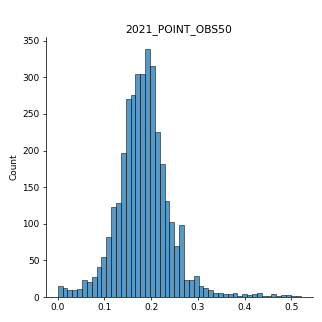

<IPython.core.display.Javascript object>


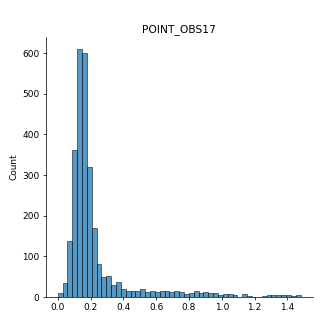

<IPython.core.display.Javascript object>


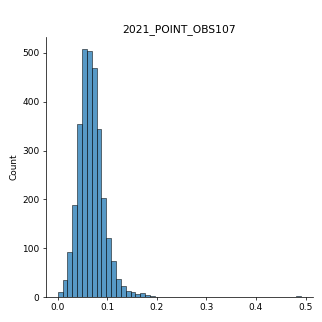

<IPython.core.display.Javascript object>


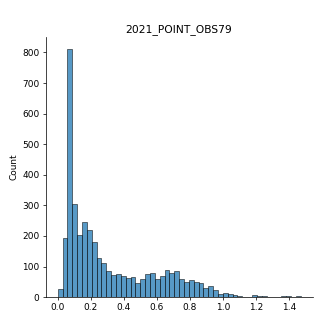

<IPython.core.display.Javascript object>


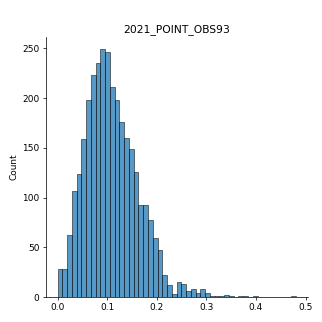

<IPython.core.display.Javascript object>


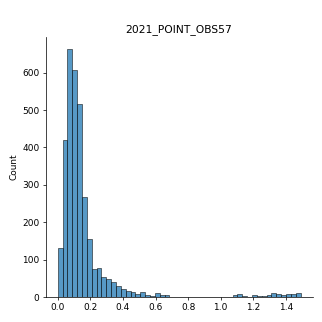

<IPython.core.display.Javascript object>


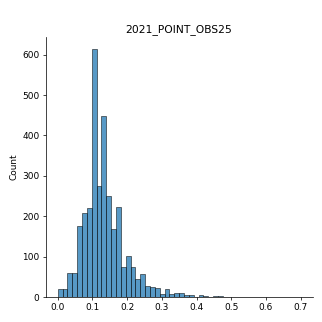

<IPython.core.display.Javascript object>


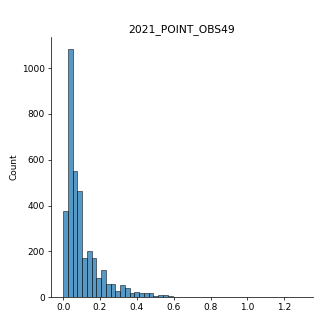

<IPython.core.display.Javascript object>


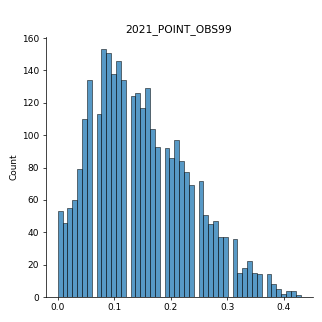

<IPython.core.display.Javascript object>


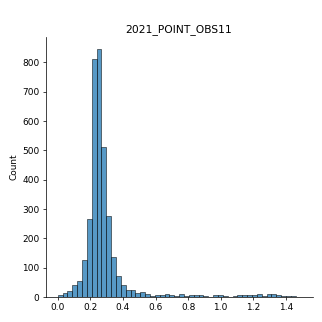

<IPython.core.display.Javascript object>


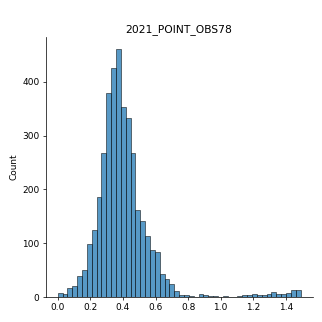

<IPython.core.display.Javascript object>


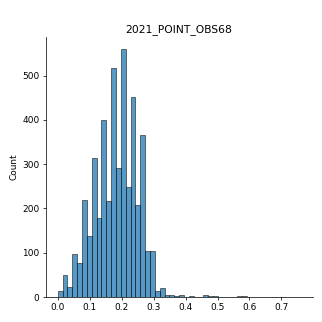

<IPython.core.display.Javascript object>


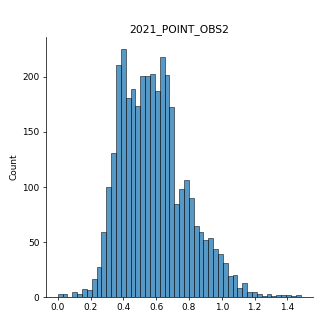

<IPython.core.display.Javascript object>


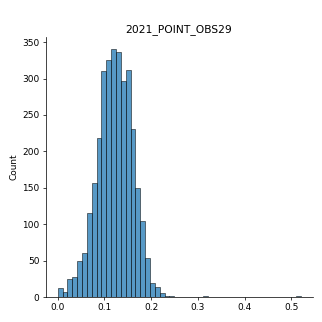

<IPython.core.display.Javascript object>


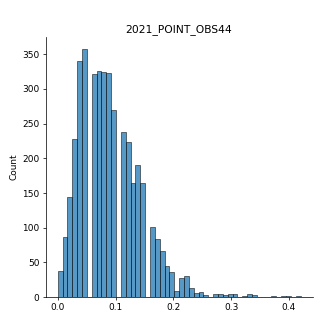

<IPython.core.display.Javascript object>


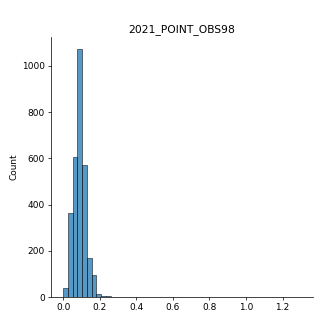

<IPython.core.display.Javascript object>


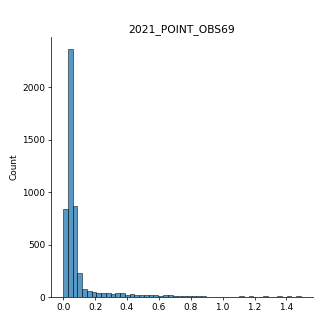

<IPython.core.display.Javascript object>


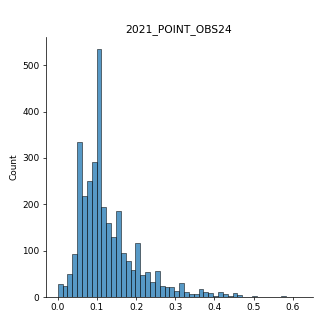

<IPython.core.display.Javascript object>


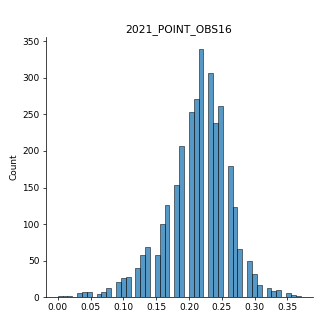

<IPython.core.display.Javascript object>


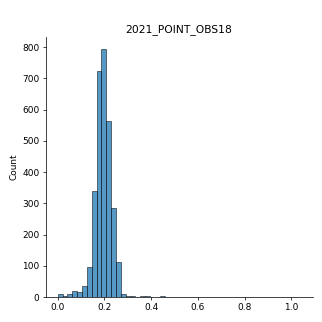

<IPython.core.display.Javascript object>


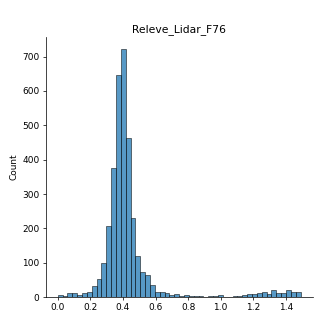

<IPython.core.display.Javascript object>


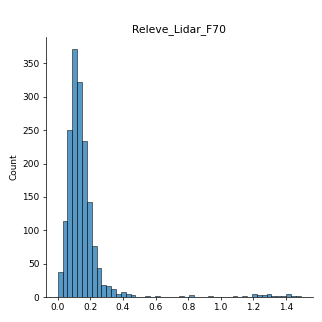

<IPython.core.display.Javascript object>


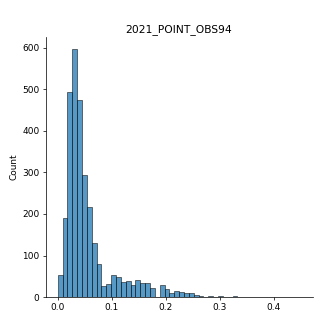

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


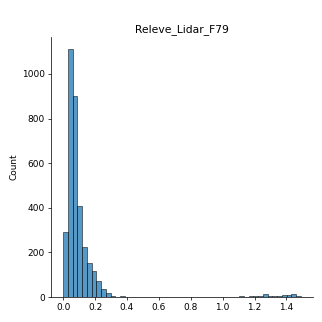

<IPython.core.display.Javascript object>


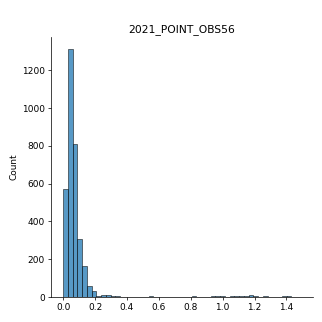

<IPython.core.display.Javascript object>


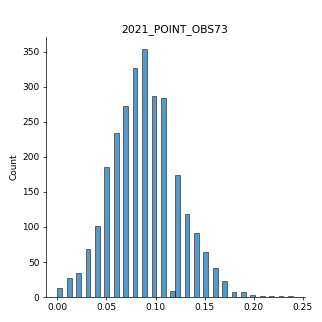

<IPython.core.display.Javascript object>


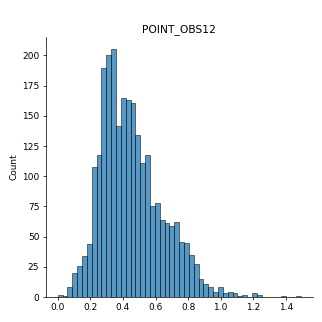

<IPython.core.display.Javascript object>


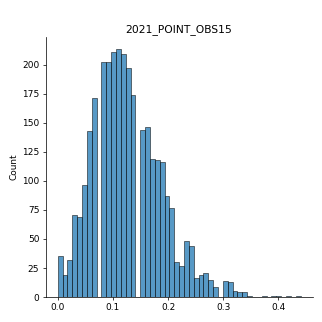

<IPython.core.display.Javascript object>


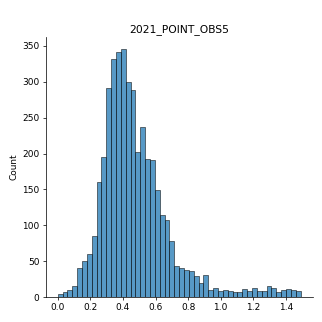

<IPython.core.display.Javascript object>


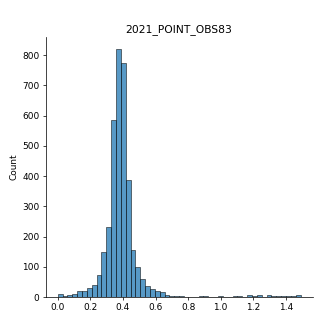

<IPython.core.display.Javascript object>


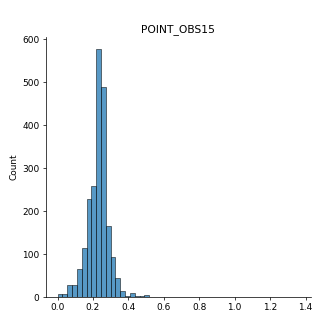

<IPython.core.display.Javascript object>


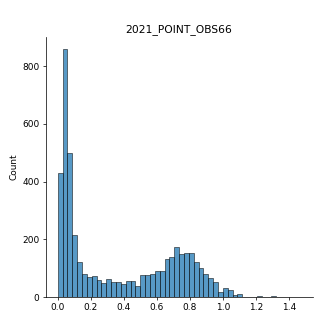

<IPython.core.display.Javascript object>


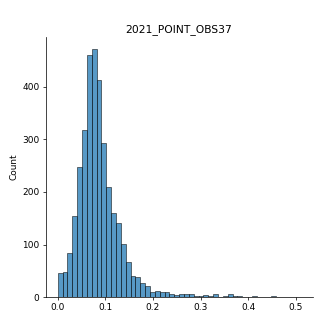

<IPython.core.display.Javascript object>


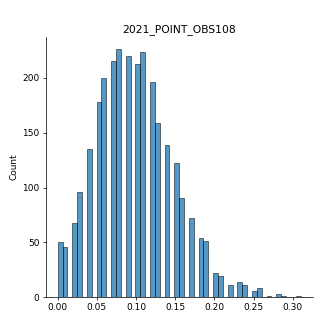

<IPython.core.display.Javascript object>


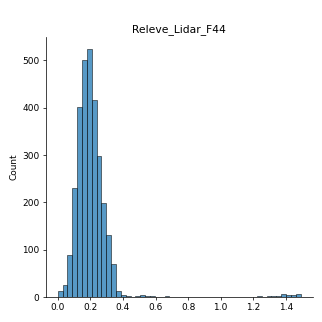

<IPython.core.display.Javascript object>


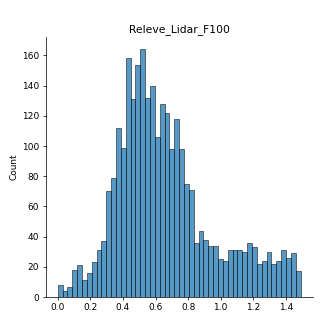

<IPython.core.display.Javascript object>


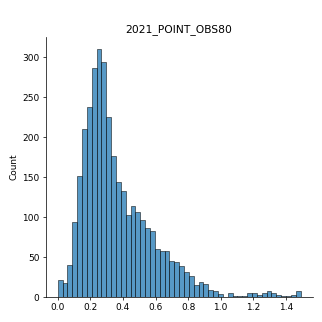

<IPython.core.display.Javascript object>


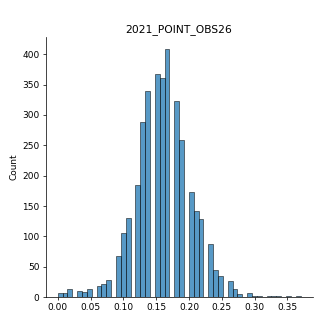

<IPython.core.display.Javascript object>


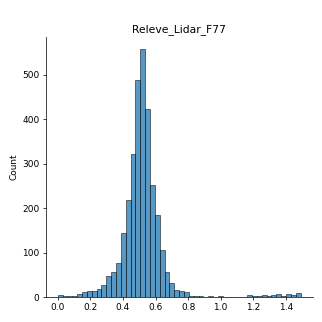

<IPython.core.display.Javascript object>


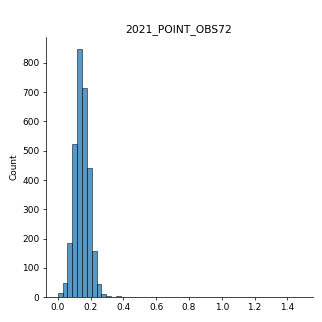

<IPython.core.display.Javascript object>


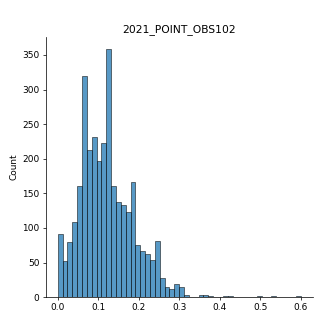

<IPython.core.display.Javascript object>


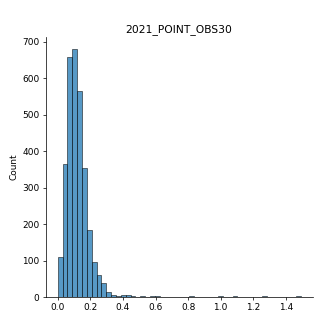

<IPython.core.display.Javascript object>


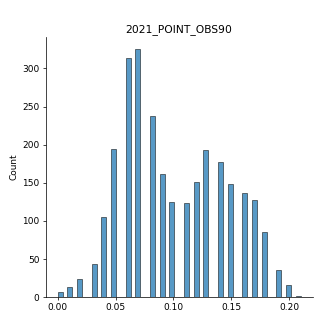

<IPython.core.display.Javascript object>


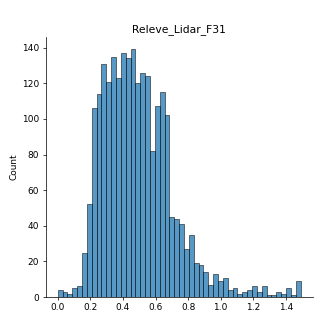

<IPython.core.display.Javascript object>


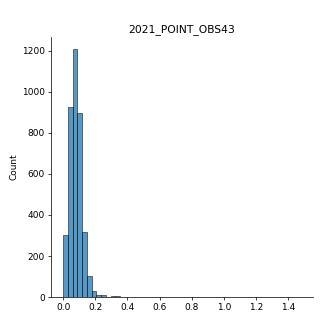

<IPython.core.display.Javascript object>


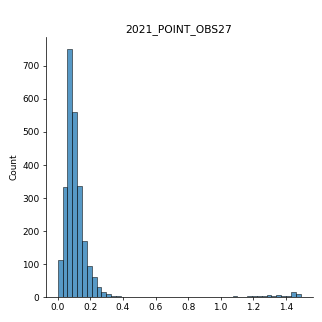

In [74]:
%matplotlib notebook
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(1,1,1)

for key in selection.keys():
    z_b_moy = nparray_clouds_dict[key][:, 2][nparray_clouds_dict[key][:, 2] < 1.5]
    sns.displot(z_b_moy, bins=50)
    plt.title("\n"+key)
    plt.tight_layout()

In [63]:
import numpy as np
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=0).fit(all_z.reshape(-1, 1))
gm.means_




array([[0.24350828],
       [9.74716798],
       [3.90417164]])

In [ ]:
gm.predict([[0, 0], [12, 3]])

<Figure size 432x288 with 0 Axes>

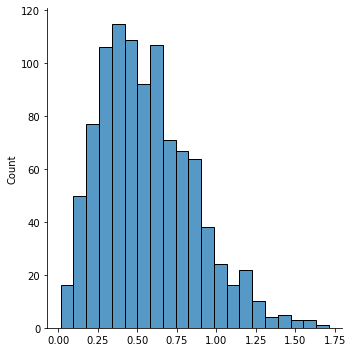

In [25]:
sigma, clip = 0.01, 0.03
plt.figure()
v1 = np.clip(
    sigma * np.random.randn(2,1000),
    a_min=-clip,
    a_max=clip,
).astype(np.float32) * 25
v2 = np.clip(
    sigma * np.random.randn(2,1000),
    a_min=-clip,
    a_max=clip,
).astype(np.float32) * 25
sns.displot(np.sqrt((v1-v2)*(v1-v2)).sum(axis=0))
plt.show()